<a href="https://colab.research.google.com/github/csargin/QClass23-24-Quantum-Machine-Learning-Task/blob/main/qml_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [139]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [140]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [141]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

"sepal width (cm)", "petal width (cm)" features will be dropped as requested in assignment

In [142]:
df.drop(columns=["sepal width (cm)", "petal width (cm)"], inplace=True)
df.head()

,sepal length (cm),petal length (cm),class
0,5.1,1.4,0
1,4.9,1.4,0
2,4.7,1.3,0
3,4.6,1.5,0
4,5.0,1.4,0


In [143]:
features = df.drop(columns=["class"], inplace=False)
labels = df["class"]

In [144]:
print(df)

     sepal length (cm)  petal length (cm)  class
0                  5.1                1.4      0
1                  4.9                1.4      0
2                  4.7                1.3      0
3                  4.6                1.5      0
4                  5.0                1.4      0
..                 ...                ...    ...
145                6.7                5.2      2
146                6.3                5.0      2
147                6.5                5.2      2
148                6.2                5.4      2
149                5.9                5.1      2

[150 rows x 3 columns]


In [145]:
print(features)

     sepal length (cm)  petal length (cm)
0                  5.1                1.4
1                  4.9                1.4
2                  4.7                1.3
3                  4.6                1.5
4                  5.0                1.4
..                 ...                ...
145                6.7                5.2
146                6.3                5.0
147                6.5                5.2
148                6.2                5.4
149                5.9                5.1

[150 rows x 2 columns]


In [146]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

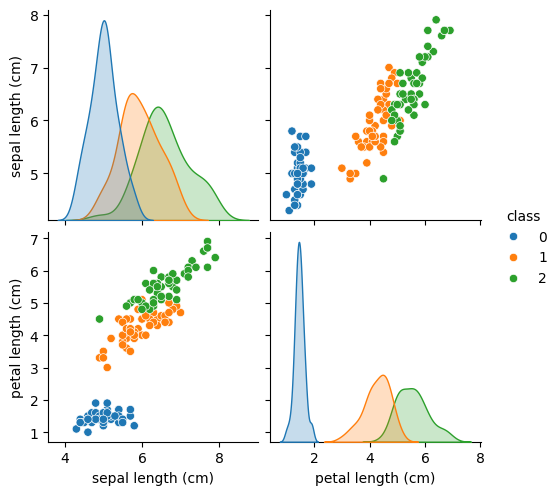

In [147]:
sns.pairplot(df, hue="class", palette="tab10")

# Model

In [148]:
#train_features, test_features, train_labels, test_labels

from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

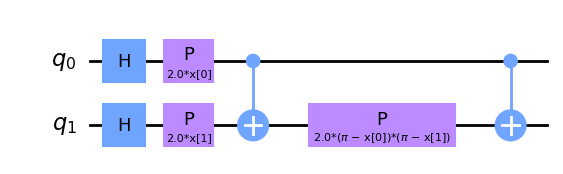

In [149]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

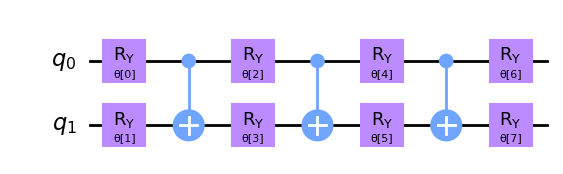

In [150]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [151]:
#Optimizer

from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [152]:
#Sampler

from qiskit.primitives import Sampler

sampler = Sampler()

In [153]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

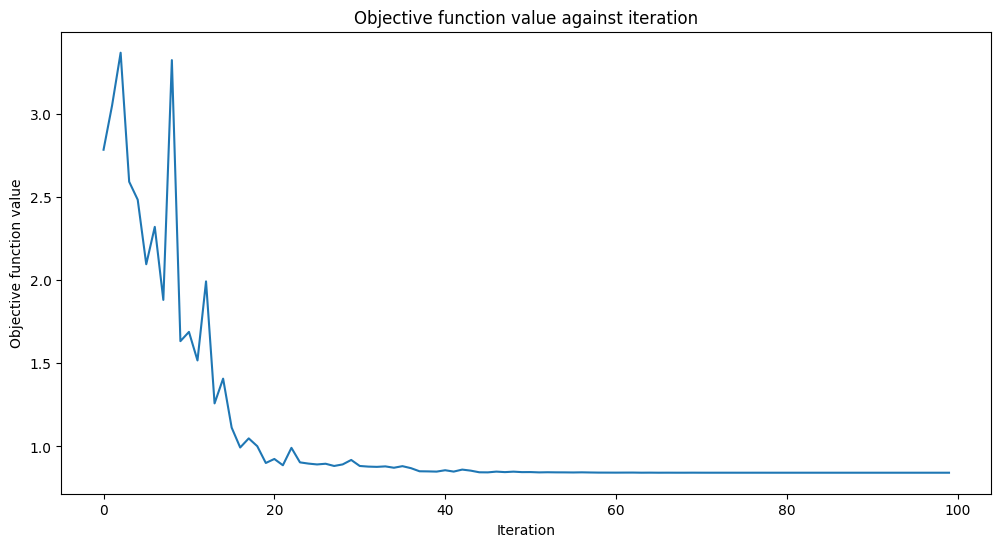

Training time: 65 seconds


In [155]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels.to_numpy())
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [156]:
train_score = vqc.score(train_features, train_labels)
test_score = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score:.2f}")

Quantum VQC on the training dataset: 0.87
Quantum VQC on the test dataset:     0.90
